# Preparing ATSD-Scenes for Training Traffic Sign Detectors

---

This notebook is part of https://github.com/risc-mi/atsd.

This notebook demonstrates how the publicly available [ATSD-Scenes](https://contentportal.asfinag.at/traffic-sign-catalogue) data set can effectively be analyzed and pre-processed for training traffic sign classifiers.

## Package Imports

In [19]:
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from skimage.io import imread
import shutil
from matplotlib import pyplot as plt

## Paths

Set `ROOT` to the path to the directory where ATSD-Scenes is located. This is the directory containing folders `"/train"` and `"/test"`.

In [2]:
ROOT = Path(r'path-to-atsd-scenes')

## Data Inspection

Load tables with meta-information about training- and test images:

In [3]:
meta_train = pd.read_csv(ROOT / 'train/meta_train.csv', index_col=0)
meta_test = pd.read_csv(ROOT / 'test/meta_test.csv', index_col=0)

In [4]:
meta_train.head()

,image_id,annotation_id,xtl,ytl,xbr,ybr,group_id,type,not_normal_to_roadway,unusual_sign,...,weather,lighting,fog,tunnel,damaged,trimmed,covered,multiple_signs_visible,caption,class_id
0,10,50,901.04,308.06,934.4,356.60,-1,plate,False,False,...,normal,normal,False,False,False,False,False,False,False,05_06
1,10,51,521.46,17.48,596.6,91.40,-1,led,False,False,...,normal,normal,False,False,False,False,False,False,False,08_01
2,11,52,955.94,286.25,975.1,305.40,-1,plate,False,False,...,normal,normal,False,False,False,False,False,False,False,01_01
3,11,53,530.20,31.55,592.9,113.14,-1,led,False,False,...,normal,normal,False,False,False,False,False,False,False,08_01
4,11,54,377.82,41.60,441.6,123.19,-1,led,False,False,...,normal,normal,False,False,False,False,False,False,False,08_01


In [5]:
meta_test.head()

,image_id,annotation_id,xtl,ytl,xbr,ybr,group_id,type,not_normal_to_roadway,unusual_sign,...,weather,lighting,fog,tunnel,damaged,trimmed,covered,multiple_signs_visible,caption,class_id
0,31,120,443.52,39.64,844.34,178.14,-1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09_02
1,32,121,601.79,0.00,1111.50,122.98,-1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09_01
2,32,122,761.08,0.00,950.42,104.87,-1,prismatic,False,False,...,normal,normal,False,False,False,False,False,False,False,08_02
3,32,123,1045.20,20.19,1101.48,76.73,-1,led,False,False,...,normal,normal,False,False,False,False,False,False,False,01_12
4,32,124,614.71,39.99,672.86,96.53,-1,led,False,False,...,normal,normal,False,False,False,False,False,False,False,01_12


As can be seen, both tables contain information about the annotations in each image (i.e., its file name), the type (material) of each annoted traffic sign, and some boolean attributes. The class id included in the table splits into the super-class and the sub-class within the super-class.

## Draw Ground Truth

This section shows the ground truth of a single image.

In [25]:
def draw_boxes(annotations, img):
    for _, row in annotations.iterrows():
        clas = row["class_id"]
        pt1 = (int(row["xtl"]), int(row["ytl"]))
        pt2 = (int(row["xbr"]), int(row["ybr"]))
        color = (255,0,0)
        cv2.rectangle(img, pt1, pt2, color, 1)
        cv2.putText(img,
                    f"{clas}",
                    (pt1[0], pt2[1] + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
    return img

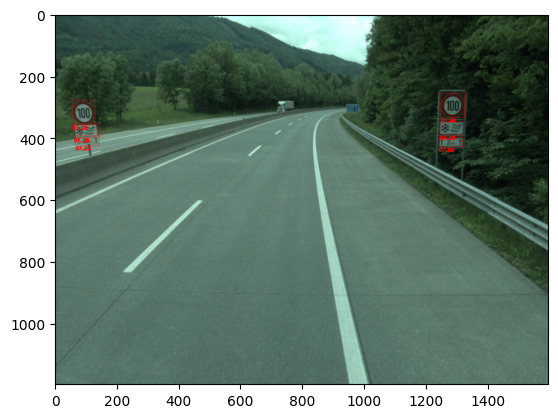

In [27]:
image_id = 99
img = imread(ROOT / f'test/imgs/{image_id}.jpg')
img = draw_boxes(meta_test[meta_test["image_id"] == image_id], img)
plt.imshow(img);

## Data Conversion to Darknet Format

This part can be used to convert the ATSD-Scenes to a format used by [Darknet](https://github.com/AlexeyAB/darknet) to train a new model.

Extraction of the detection super-class of the class_id. 

In [7]:
meta_train["detection_class_id"] = meta_train["class_id"].str.split('_').str[0]
meta_test["detection_class_id"] = meta_test["class_id"].str.split('_').str[0]

Filtering all unused classes, in this case special and TB/TCS.

In [8]:
filter_detection_classes = ["xx","09"]
meta_train = meta_train[~meta_train['detection_class_id'].isin(filter_detection_classes)]
meta_test = meta_test[~meta_test['detection_class_id'].isin(filter_detection_classes)]
meta_train['detection_class_id'] = meta_train['detection_class_id'].astype(int)
meta_test['detection_class_id'] = meta_test['detection_class_id'].astype(int)

Converting bboxes and exporting images to new dataset folder following the darknet schema: `<object-class> <x_center> <y_center> <width> <height>`

In [9]:
def convert_box_sizes(image_path, detections):
    imw, imh = np.array(Image.open(image_path).size).astype("float32")
    center_x = ((detections["xtl"]+ detections["xbr"]) / 2 / imw).tolist()
    center_y = ((detections["ytl"]+ detections["ybr"]) / 2 /imh).tolist()
    width = ((detections["xbr"] - detections["xtl"]) / imw).tolist()
    height = ((detections["ybr"] - detections["ytl"]) / imh).tolist()
    class_id = (detections["detection_class_id"]).tolist()
    # <object-class> <x_center> <y_center> <width> <height>
    return list(zip(class_id, center_x, center_y, width, height))

In [ ]:
output_folder_name = 'yolo_export'

output_path = Path(ROOT / output_folder_name)
output_path.mkdir(exist_ok=True)

for meta, path, meta_output_path in ((meta_train, ROOT / 'train/imgs', output_path / 'train.txt'),(meta_test, ROOT / 'test/imgs', output_path / 'test.txt')):
    for image_path in path.glob("*.jpg"):
        image_id = int(image_path.stem)
        annotations = meta[meta["image_id"] == image_id]
        # Copy file
        shutil.copy(image_path, output_path)
        annotations_converted = convert_box_sizes(image_path, annotations)
        with open(output_path / image_path.with_suffix('.txt').name, "w") as annotation_file:
            for row in annotations_converted:
                annotation_file.write(" ".join(map(str, row)))
                annotation_file.write("\n")
    with open(meta_output_path, "w") as meta_file:
        meta_file.write("\n".join(list(map(lambda p: output_folder_name+"/"+p.name, path.glob("*.jpg")))))